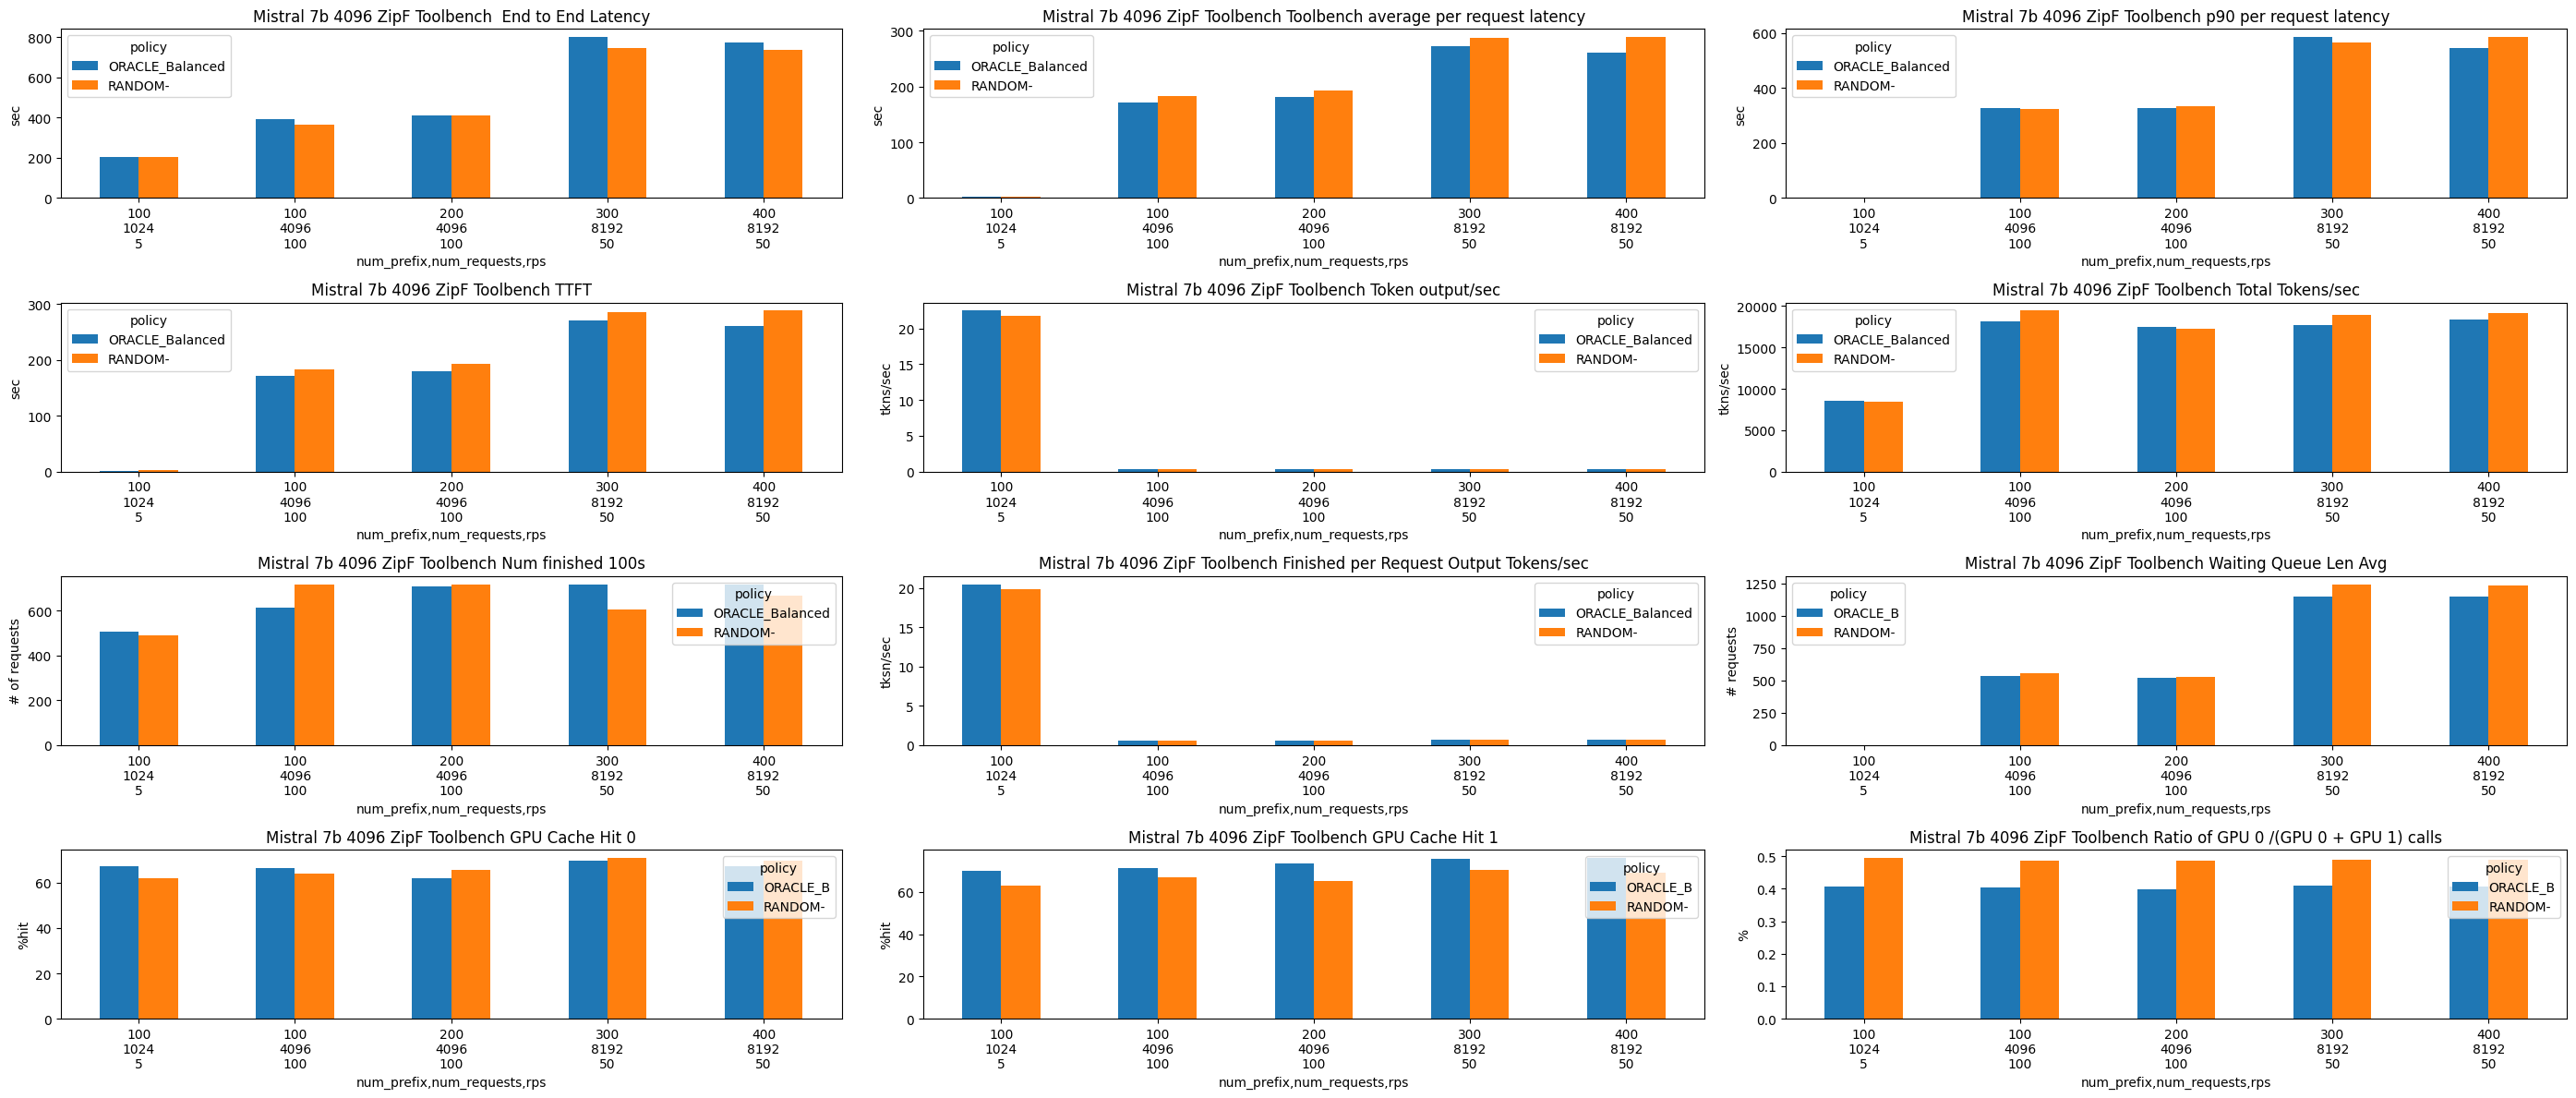

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np

def extract_policy_and_number(log_file):
    overall_latencies = []
    overall_throughput = []
    request_latencies = []
    counts_all = []
    request_llm_metrics = []
    finished_llm_metrics = []

    with open(log_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # Extract lines containing overall latency
            if 'Overall Latency' in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Overall Latency: (.*)', line)
                if match:
                    # if int(match.group(2)) == 300:
                    #     continue
                    overall_latencies.append({
                        "model_name": match.group(1),
                        "num_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": int(match.group(5)),
                        "policy": match.group(6).replace("CUSTOM-CustomPolicyType.", ""),
                        "latency": float(match.group(7))
                    })
            elif 'Overall Throughput' in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Overall Throughput: (.*)', line)
                if match:
                    # if int(match.group(2)) == 300:
                    #     continue
                    overall_throughput.append({
                        "model_name": match.group(1),
                        "num_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": int(match.group(5)),
                        "policy": match.group(6).replace("CUSTOM-CustomPolicyType.", ""),
                        "throughput": float(match.group(7))
                    })
            elif "Overall Request Latency:" in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Overall Request Latency: (.*), STD: (.*), P90: (.*)', line)
                if match:
                    # if int(match.group(2)) == 300:
                    #     continue
                    request_latencies.append({
                        "model_name": match.group(1),
                        "num_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": int(match.group(5)),
                        "policy": match.group(6).replace("CUSTOM-CustomPolicyType.", ""),
                        "avg_latency": float(match.group(7)),
                        "std": float(match.group(8)),
                        "p90": float(match.group(9))
                    })
            elif "Average TTFT:" in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Average TTFT: (.*), Average TOPT: (.*), Throughput ToksPerSec: (.*)', line)
                if match:
                    # if int(match.group(2)) == 300:
                    #     continue
                    request_llm_metrics.append({
                        "model_name": match.group(1),
                        "num_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": int(match.group(5)),
                        "policy": match.group(6).replace("CUSTOM-CustomPolicyType.", ""),
                        "ttft": float(match.group(7)),
                        "topt": float(match.group(8)),
                        "throughput_tkns_per_sec": float(match.group(9))
                    })      
            elif "Num Finished Requests: " in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Num Finished Requests: (.*), Finished Throughput ToksPerSec: (.*)', line)
                if match:
                    # if int(match.group(2)) == 300:
                    #     continue
                    finished_llm_metrics.append({
                        "model_name": match.group(1),
                        "num_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": int(match.group(5)),
                        "policy": match.group(6).replace("CUSTOM-CustomPolicyType.", ""),
                        "num_finished": int(match.group(7)),
                        "throughput_finished_tkns_per_sec": float(match.group(8)),
                    })      
            elif "Counts:" in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Counts: (.*)', line)
                if match:
                    count_ratio = eval(match.group(7))
                    ratios = {
                        0: 0,
                        1: 0
                    }
                    for key in count_ratio:
                        ratios[key] = float(count_ratio[key])
                    counts_all.append({
                        "model_name": match.group(1),
                        "num_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": int(match.group(5)),
                        "policy": match.group(6).replace("CUSTOM-CustomPolicyType.", ""),
                        "counts_all": ratios,
                        "ratio": ratios[0]/(ratios[0]+ratios[1])
                    })    

    return overall_latencies, overall_throughput, request_latencies, counts_all, request_llm_metrics, finished_llm_metrics

# log_file = 'perf_results_random_vs_oracle_vs_custom_mistral_2_profile_new_results.log'
log_file = 'tool_bench_4096_zipf.log'
title_prefix = "Mistral 7b 4096 ZipF Toolbench"
# log_file = 'tool_bench_4096_llama.log'
# title_prefix = "Llama7b 4096 Toolbench"
result, overall_throughput, request_latencies, counts_all, request_llm_metrics, finished_llm_metrics = extract_policy_and_number(log_file)

fig, axes = plt.subplots(4, 3, figsize=(28, 12))

# Plotting Mistral7b 4096 End to End Latency
df = pd.DataFrame(result)
df = df.drop("model_name", axis=1)
df = df.drop('percent_random_prefixes', axis=1)
df['policy'] = df['policy'].replace('ORACLE', 'ORACLE_Imbalance').replace("ORACLE_B", "ORACLE_Balanced")
df = df.groupby(['num_prefix', 'num_requests', 'rps', 'policy'])['latency'].mean().unstack()
plot = df.plot(kind='bar', ax=axes[0, 0], title=f"{title_prefix}  End to End Latency", rot=0, ylabel="sec")
x_labels = []
for idx in df.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)

plot.set_xticklabels(x_labels)
# Plotting Mistral7b 4096 average per request latency
request_latency_df = pd.DataFrame(request_latencies)
request_latency_df = request_latency_df.drop("model_name", axis=1)
request_latency_df = request_latency_df.drop("percent_random_prefixes", axis=1)
request_latency_df['policy'] = request_latency_df['policy'].replace('ORACLE', 'ORACLE_Imbalance').replace("ORACLE_B", "ORACLE_Balanced")
request_latency_df = request_latency_df.groupby(['num_prefix', 'num_requests', 'rps', 'policy'])["avg_latency"].mean().unstack()
plot = request_latency_df.plot(kind='bar', ax=axes[0, 1], title=f"{title_prefix} Toolbench average per request latency", rot=0, ylabel="sec")
x_labels = []
for idx in request_latency_df.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)
# plt.ylabel("sec")


# Plotting Mistral7b 4096 p90 per request latency
request_latency_df_90 = pd.DataFrame(request_latencies)
request_latency_df_90 = request_latency_df_90.drop("model_name", axis=1)
request_latency_df_90 = request_latency_df_90.drop("percent_random_prefixes", axis=1)
request_latency_df_90['policy'] = request_latency_df_90['policy'].replace('ORACLE', 'ORACLE_Imbalance').replace("ORACLE_B", "ORACLE_Balanced")
request_latency_df_90 = request_latency_df_90.groupby(['num_prefix','num_requests', 'rps', 'policy'])["p90"].mean().unstack()
plot = request_latency_df_90.plot(kind='bar', ax=axes[0, 2], title=f"{title_prefix} p90 per request latency", rot=0, ylabel="sec")
x_labels = []
for idx in request_latency_df.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)
# plt.ylabel("sec")

# Plotting Mistral Ratio of GPU 0 /(GPU 0 + GPU 1) calls
count_df = pd.DataFrame(counts_all)
# count_df = count_df.drop("model_name", axis=1)
count_df = count_df.drop("percent_random_prefixes", axis=1)
count_df['policy'] = count_df['policy'].replace('ORACLE', 'ORACLE_Imbalance')
count_df = count_df.groupby(['num_prefix','num_requests', 'rps', 'policy'])["ratio"].mean().unstack()
plot = count_df.plot(kind='bar', ax=axes[3, 2], title=f"{title_prefix} Ratio of GPU 0 /(GPU 0 + GPU 1) calls", rot=0, ylabel="%")
x_labels = []
for idx in count_df.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)
# Add TTFT and TOPT
request_llm_metrics_df_ttft = pd.DataFrame(request_llm_metrics)
request_llm_metrics_df_ttft = request_llm_metrics_df_ttft.drop("model_name", axis=1)
request_llm_metrics_df_ttft = request_llm_metrics_df_ttft.drop("percent_random_prefixes", axis=1)
request_llm_metrics_df_ttft['policy'] = request_llm_metrics_df_ttft['policy'].replace('ORACLE', 'ORACLE_Imbalance').replace("ORACLE_B", "ORACLE_Balanced")
request_llm_metrics_df_ttft = request_llm_metrics_df_ttft.groupby(['num_prefix','num_requests', 'rps', 'policy'])["ttft"].mean().unstack()
plot = request_llm_metrics_df_ttft.plot(kind='bar', ax=axes[1, 0], title=f"{title_prefix} TTFT", rot=0, ylabel="sec")
x_labels = []
for idx in request_llm_metrics_df_ttft.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)

request_llm_metrics_df_topt = pd.DataFrame(request_llm_metrics)
request_llm_metrics_df_topt = request_llm_metrics_df_topt.drop("model_name", axis=1)
request_llm_metrics_df_topt = request_llm_metrics_df_topt.drop("percent_random_prefixes", axis=1)
request_llm_metrics_df_topt['policy'] = request_llm_metrics_df_topt['policy'].replace('ORACLE', 'ORACLE_Imbalance').replace("ORACLE_B", "ORACLE_Balanced")
request_llm_metrics_df_topt = request_llm_metrics_df_topt.groupby(['num_prefix','num_requests', 'rps', 'policy'])["topt"].mean().unstack()
plot = request_llm_metrics_df_topt.plot(kind='bar', ax=axes[1, 1], title=f"{title_prefix} Token output/sec", rot=0, ylabel="tkns/sec")
x_labels = []
for idx in request_llm_metrics_df_topt.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)

request_llm_metrics_tkns_per_sec = pd.DataFrame(request_llm_metrics)
request_llm_metrics_tkns_per_sec = request_llm_metrics_tkns_per_sec.drop("model_name", axis=1)
request_llm_metrics_tkns_per_sec = request_llm_metrics_tkns_per_sec.drop("percent_random_prefixes", axis=1)
request_llm_metrics_tkns_per_sec['policy'] = request_llm_metrics_tkns_per_sec['policy'].replace('ORACLE', 'ORACLE_Imbalance').replace("ORACLE_B", "ORACLE_Balanced")
request_llm_metrics_df = request_llm_metrics_tkns_per_sec.groupby(['num_prefix','num_requests', 'rps', 'policy'])["throughput_tkns_per_sec"].mean().unstack()
plot = request_llm_metrics_df.plot(kind='bar', ax=axes[1, 2], title=f"{title_prefix} Total Tokens/sec", rot=0, ylabel="tkns/sec")
x_labels = []
for idx in request_llm_metrics_df.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)

request_llm_metrics_df_num__finished = pd.DataFrame(finished_llm_metrics)
request_llm_metrics_df_num__finished = request_llm_metrics_df_num__finished.drop("model_name", axis=1)
request_llm_metrics_df_num__finished = request_llm_metrics_df_num__finished.drop("percent_random_prefixes", axis=1)
request_llm_metrics_df_num__finished['policy'] = request_llm_metrics_df_num__finished['policy'].replace('ORACLE', 'ORACLE_Imbalance').replace("ORACLE_B", "ORACLE_Balanced")
request_llm_metrics_df = request_llm_metrics_df_num__finished.groupby(['num_prefix','num_requests', 'rps', 'policy'])["num_finished"].mean().unstack()
plot = request_llm_metrics_df.plot(kind='bar', ax=axes[2, 0], title=f"{title_prefix} Num finished 100s", rot=0, ylabel="# of requests")
x_labels = []
for idx in request_llm_metrics_df.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)

finished_llm_metrics_tkns_per_sec_request = pd.DataFrame(finished_llm_metrics)
finished_llm_metrics_tkns_per_sec_request = finished_llm_metrics_tkns_per_sec_request.drop("model_name", axis=1)
finished_llm_metrics_tkns_per_sec_request = finished_llm_metrics_tkns_per_sec_request.drop("percent_random_prefixes", axis=1)
finished_llm_metrics_tkns_per_sec_request['policy'] = finished_llm_metrics_tkns_per_sec_request['policy'].replace('ORACLE', 'ORACLE_Imbalance').replace("ORACLE_B", "ORACLE_Balanced")
request_llm_metrics_df = finished_llm_metrics_tkns_per_sec_request.groupby(['num_prefix','num_requests', 'rps', 'policy'])["throughput_finished_tkns_per_sec"].mean().unstack()
plot = request_llm_metrics_df.plot(kind='bar', ax=axes[2, 1], title=f"{title_prefix} Finished per Request Output Tokens/sec", rot=0, ylabel="tksn/sec")
x_labels = []
for idx in request_llm_metrics_df.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)


# Adjust layout
# plt.tight_layout()
# plt.savefig("Mistral7b 4096 Toolbench_grid_results_latency.png")

policy_data = []
current_policy_info = {}
max_hit_rate_gpu0 = 0.0
max_hit_rate_gpu1 = 0.0
waiting_queue_lenghts = []

with open(log_file, 'r') as file:
    for line in file:
        if "=====STARTING Policy" in line:
            # At the start of a new policy, store the max hit rates for both GPUs from the previous group if present
            if waiting_queue_lenghts:
                avg_waiting_queue_len = sum(waiting_queue_lenghts) / len(waiting_queue_lenghts)
            else:
                avg_waiting_queue_len = 0
            if current_policy_info:
                current_policy_info['max_tree_cache_hit_rate_gpu0'] = max_hit_rate_gpu0
                current_policy_info['max_tree_cache_hit_rate_gpu1'] = max_hit_rate_gpu1
                current_policy_info['avg_waiting_queue_len'] = avg_waiting_queue_len
                policy_data.append(current_policy_info)

            # Resetting for the new group
            current_policy_info = {}
            max_hit_rate_gpu0 = 0.0
            max_hit_rate_gpu1 = 0.0
            waiting_queue_lenghts = []
            
            # Extract policy and other properties
            match = re.search(r"=====STARTING Policy (.+?), (\d+) WORKLOADS, ([\d.]+) NON-SHARED, (\d+) REQUESTS, (\d+) REQ/s", line)
            if match:
                current_policy_info['policy'] = match.group(1).replace("DataParallelRuntimeSelectionPolicy.", "").replace("CUSTOM-CustomPolicyType.", "")
                current_policy_info['num_different_long_prefix'] = int(match.group(2))
                current_policy_info['percent_random_prefixes'] = float(match.group(3))
                current_policy_info['num_requests'] = int(match.group(4))
                current_policy_info['rps'] = int(match.group(5))
                
        elif "tree_cache_hit_rate" in line:
            gpu_id_match = re.search(r"GPU: (\d)", line)
            hit_rate_match = re.search(r"tree_cache_hit_rate: ([\d.]+)%", line)
            waiting_queue_length = re.search(r"#remaining_req: ([\d.]+).", line)
            if waiting_queue_length:
                waiting_que_len = float(waiting_queue_length.group(1))
                waiting_queue_lenghts.append(waiting_que_len)

            if gpu_id_match and hit_rate_match:
                gpu_id = int(gpu_id_match.group(1))
                hit_rate = float(hit_rate_match.group(1))

                if gpu_id == 0:
                    max_hit_rate_gpu0 = max(max_hit_rate_gpu0, hit_rate)
                elif gpu_id == 1:
                    max_hit_rate_gpu1 = max(max_hit_rate_gpu1, hit_rate)

# Append the last group's data
if current_policy_info:
    current_policy_info['max_tree_cache_hit_rate_gpu0'] = max_hit_rate_gpu0
    current_policy_info['max_tree_cache_hit_rate_gpu1'] = max_hit_rate_gpu1
    if waiting_queue_lenghts:
        avg_waiting_queue_len = sum(waiting_queue_lenghts) / len(waiting_queue_lenghts)
    else:
        avg_waiting_queue_len = 0
    current_policy_info['avg_waiting_queue_len'] = avg_waiting_queue_len
    policy_data.append(current_policy_info)


# Creating a DataFrame from the list of dictionaries
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting Mistral GPU Cache Hit 0
tree_cache_df = pd.DataFrame(policy_data)
tree_cache_df = tree_cache_df.drop('percent_random_prefixes', axis=1)
tree_cache_df = tree_cache_df.rename(columns={'num_different_long_prefix': 'num_prefix'})

tree_cache_df_gpu0 = tree_cache_df.groupby(['num_prefix',  'num_requests', 'rps', 'policy'])["max_tree_cache_hit_rate_gpu0"].mean().unstack()
plot = tree_cache_df_gpu0.plot(kind='bar', ax=axes[3, 0], title=f"{title_prefix} GPU Cache Hit 0", rot=0,  ylabel="%hit")
x_labels = []
for idx in tree_cache_df_gpu0.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)

# Plotting Mistral GPU Cache Hit 1
tree_cache_df_gpu1 = tree_cache_df.groupby(['num_prefix', 'num_requests', 'rps', 'policy'])["max_tree_cache_hit_rate_gpu1"].mean().unstack()
plot = tree_cache_df_gpu1.plot(kind='bar', ax=axes[3, 1], title=f"{title_prefix} GPU Cache Hit 1", rot=0, ylabel="%hit")
x_labels = []
for idx in tree_cache_df_gpu1.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)

tree_cache_df_gpu1 = tree_cache_df.groupby(['num_prefix', 'num_requests', 'rps', 'policy'])["avg_waiting_queue_len"].mean().unstack()
plot = tree_cache_df_gpu1.plot(kind='bar', ax=axes[2, 2], title=f"{title_prefix} Waiting Queue Len Avg", rot=0, ylabel="# requests")
x_labels = []
for idx in tree_cache_df_gpu1.index:
    label = '\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)

# plt.ylabel("%hit")
# fig.delaxes(axes[2,2])
# fig.delaxes(axes[3,2])

# Adjust layout
plt.tight_layout()
# plt.savefig("mistral_gpu_cache_hit_0.png")
# plt.savefig("Mistral7b 4096 Toolbench_gpu_cache_hit_0.png")
plt.show()

In [2]:
df

policy                       ORACLE_Balanced     RANDOM-
num_prefix num_requests rps                             
100        1024         5         202.896690  204.838857
           4096         100       392.677533  365.842361
200        4096         100       408.602522  412.483093
300        8192         50        800.926679  747.240859
400        8192         50        772.227251  737.610775

In [4]:
# TTFT improvement is highest when lower RPS
request_llm_metrics_df_ttft

policy                       ORACLE_Balanced     RANDOM-
num_prefix num_requests rps                             
25         1024         10         40.046474   47.225409
                        50         71.248206   74.041928
                        100        84.753488   92.550452
                        300        97.568653  100.091604
50         1024         10         51.200650   62.282710
                        50         77.868101   81.473362
                        100        79.695643   88.694397
75         1024         10         60.673254   78.880111
                        50         82.634579   94.983994
                        100        91.217883  100.220091
100        1024         5          41.083321   53.313443
                        16         72.748793   87.760441
           2048         16        137.466266  167.932072
           4096         16        233.688617  262.847331
                        25        286.501247  318.317603
                        50        310.747485  346.929168
                        100       320.667821  346.240634
200        4096         5         115.020011  156.332621
                        25        302.031424  345.172152
                        50        337.923266  379.647454
                        100       359.327783  404.331240
300        8192         25        690.942794  778.877837
                        50        700.593329  802.727838
400        8192         50        756.122824  848.571570

In [ ]:
request_latency_df

In [ ]:
request_llm_metrics_df_ttft